# 📘 Learning Rate Strategies in Reinforcement Learning

This notebook explores and compares different learning rate adaptation strategies in the context of optimization under noise — with a particular focus on their potential application to reinforcement learning (RL).  
We implement and analyze three optimization algorithms:

- **Gradient Descent** with optional adaptive learning rate,
- **Adam** extended with a path-based adaptation mechanism (CLARA),
- **Evolution Strategies** with cumulative step-size control.

The core idea is to investigate how learning rates can be adapted dynamically using information from the **history of update directions**, especially under **noisy and ill-conditioned settings** that are typical in RL.  
To this end, we introduce a CLARA-like mechanism that accumulates update directions over time and adjusts the learning rate based on the **norm and consistency** of these updates. We also include noisy versions of benchmark functions (Sphere, Ellipsoid) to simulate stochastic environments.

This notebook serves as an experimental framework for analyzing the stability, convergence, and robustness of different learning rate strategies — and lays the groundwork for applying these insights to deep RL.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

---
## 🧮 Objective Functions and Gradients

Defines the Sphere and Ellipsoid test functions along with their gradients, both clean and noisy. These serve as toy problems to study optimization under noise and ill-conditioning.


In [2]:
# Define the Sphere function (a simple quadratic function)
def sphere(x):
    return np.sum(x**2)

# Gradient of the Sphere function (analytically known)
def grad_sphere(x):
    return 2 * x

# Define a noisy version of the Sphere function (adds multiplicative noise)
def noisy_sphere(x):
    noise = np.random.normal(loc=0, scale=0.01)  # Small Gaussian noise
    return np.sum(x**2) * np.exp(noise)

# Gradient of the noisy Sphere function (adds noise to the gradient)
def noisy_grad_sphere(x):
    noise = np.random.randn(*x.shape) * 0.5  # Gaussian noise scaled by 0.5
    return 2 * (1 + noise) * x

In [3]:
cond = 1e6

# Define the Ellipsoid function (a generalization of the Sphere function with conditioning)
def ellipsoid(x, cond=cond):
    return sum(cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)**2)

# Gradient of the Ellipsoid function (analytically known)
def grad_ellipsoid(x, cond=cond):
    noise = np.random.randn(*x.shape)  # Additive Gaussian noise
    return 2 * cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x) + noise * np.linalg.norm(x)

# Define a noisy version of the Ellipsoid function (adds multiplicative noise)
def noisy_ellipsoid(x, cond=cond):
    noise = np.random.normal(loc=0, scale=0.01)  # Small Gaussian noise
    return sum(cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)**2) * np.exp(noise)

# Gradient of the noisy Ellipsoid function (adds noise to the gradient)
def noisy_grad_ellipsoid(x, cond=cond):
    noise = np.random.randn(*x.shape) * 0.5  # Gaussian noise scaled by 0.5
    return 2 * (1 + noise) * cond**(np.arange(len(x)) / (len(x) - 1 + 1e-9)) * np.asarray(x)

----
## ⚙️ Optimizers Implementation

### Evolution Strategy (ES)

Implements a simple (μ, λ)-evolution strategy with adaptive step size control using a CLARA-style cumulative path update.

In [4]:
def evolution_strategy(f, x0, sigma, iterations=100, mu=5, lambda_=10):
    """Implements an Evolution Strategy (ES) optimization algorithm with Cumulative LeArning Rate Adaptation (CLARA)."""
    
    dim = len(x0)
    x = x0

    # Initialize path variable, smoothing and damping factors for Cumulative LeArning Rate Adaptation (CLARA)
    path = np.zeros(dim)
    c = 0.2
    d = 1

    # Initialize return variables
    candidate_solutions = []
    step_size = []
    path_norm = []
    step_norm = []

    weights = np.linspace(1, 2, mu)  # Assign higher weight to best individuals
    weights /= weights.sum()  # Normalize weights to sum to 1

    for i in range(iterations):
        # Generate offspring
        pop = np.random.randn(lambda_, dim)

        # Select mu best individuals
        selected = pop[np.argsort([f(x + sigma * ind) for ind in pop])[:mu]]

        # Update current solution
        step = np.sum(selected.T * weights, axis=1)
        x = x + sigma * step
        candidate_solutions.append(x)

        # Update path
        path = (1 - c) * path + np.sqrt(c * (2 - c)) * step
        path_norm.append(np.linalg.norm(path))
        step_norm.append(np.linalg.norm(step))

        # Update step-size
        sigma = sigma * np.exp(c / (2 * d) * ((np.linalg.norm(path)**2 / dim) - 1))
        step_size.append(sigma)


        print(f'Iteration {i}: current fitness = {f(x)}')

    return candidate_solutions, step_size, path_norm, step_norm

### Gradient Descent with CLARA

Standard gradient descent with optional adaptive learning rate based on a cumulative path norm (CLARA-like adaptation).

In [5]:
def gradient_descent(gradient, x0, lr=0.1, iterations=100, adapt_lr=True):
    """
    Performs gradient descent to minimize a function.

    :param gradient: Function that computes the gradient ∇f(x).
    :param x0: Initial guess (NumPy array).
    :param lr: Learning rate (step size).
    :param iterations: Number of iterations.
    :return: Final optimized value of x.
    """
    x = x0  # Initialize x
    dim = len(x0)  # Get dimension of search space

    # Initialize path variable, smoothing and damping factors for Cumulative LeArning Rate Adaptation (CLARA)
    path = np.zeros(dim)
    c = 0.2
    d = 1

    # Initialize return variables
    candidate_solutions = []
    learning_rate = []
    path_norm = []
    gradient_norm = []

    for _ in range(iterations):
        grad = gradient(x)  # Compute gradient
        step = grad.copy()
        if adapt_lr:
            step /= np.linalg.norm(step)  # TODO: Handle division by zero
        x = x - lr * step # Update step

        # Update path
        path = (1 - c) * path + np.sqrt(c * (2 - c)) * step

        # Update learning rate
        if adapt_lr:
            lr = lr * np.exp(c / (2 * d) * (np.linalg.norm(path)**2 / dim - 1))

        candidate_solutions.append(x)
        learning_rate.append(lr)
        path_norm.append(np.linalg.norm(path))
        gradient_norm.append(np.linalg.norm(grad))

    print('Optimized x: ', x)

    return candidate_solutions, learning_rate, path_norm, gradient_norm

### Adam Optimizer with Path-based Adaptation

Extends Adam with path accumulation and CLARA-style adaptive learning rate. The update direction is normalized and used to control the learning rate based on its alignment over time.

In [6]:
def adam(gradient, x0, lr=0.1, iterations=100, adapt_lr=True):
    """
    Performs gradient descent to minimize a function.

    :param gradient: Function that computes the gradient ∇f(x).
    :param x0: Initial guess (NumPy array).
    :param lr: Learning rate (step size).
    :param iterations: Number of iterations.
    :return: Final optimized value of x.
    """
    x = x0  # Initialize x
    dim = len(x0)  # Get dimension of search space

    # Initialize path variable, smoothing and damping factors for Cumulative LeArning Rate Adaptation (CLARA)
    path = np.zeros(dim)
    c = 0.2
    d = 1

    # Initialize Adam variables for calculating first and second moments
    m = np.zeros(dim)
    v = np.zeros(dim)
    beta1 = 0.9
    beta2 = 0.999

    # Initialize return variables
    candidate_solutions = []
    learning_rate = []
    path_norm = []
    gradient_norm = []

    for i in range(iterations):
        grad = gradient(x)  # Compute gradient

        # Update step
        m = beta1 * m + (1 - beta1) * grad
        m_hat = m / (1 - beta1**(i + 1))
        v = beta2 * v + (1 - beta2) * grad**2
        v_hat = v / (1 - beta2**(i + 1))
        step_adam = m_hat / (np.sqrt(v_hat) + 1e-8)
        if adapt_lr:
            step_adam /= np.linalg.norm(step_adam)  # TODO: Handle division by zero
        # Update solution
        x = x - lr * step_adam

        # Update path of steps taken
        path = (1 - c) * path + np.sqrt(c * (2 - c)) * step_adam

        # Update learning rate
        if adapt_lr:
            lr = lr * np.exp(c / (2 * d) * (np.linalg.norm(path)**2 / dim - 1))

        candidate_solutions.append(x)
        learning_rate.append(lr)
        path_norm.append(np.linalg.norm(path))
        gradient_norm.append(np.linalg.norm(grad))

    print('Optimized x: ', x)

    return candidate_solutions, learning_rate, path_norm, gradient_norm

----
## 🚀 Optimizer Configuration and Execution  
Sets experiment parameters, selects the optimizer and objective function, and runs the optimization loop for a given number of iterations.


In [7]:
dim = 2
x0 = np.ones(dim)
budget = 1000

# Choose the objective function (e.g. noisy gradient of the ill-conditioned ellipsoid)
objective_gradient = noisy_grad_ellipsoid

# Set method-specific learning rates
lr_gd = 1e-10         # Much smaller for stability in vanilla GD
lr_adam = 1e6         # Keep large to test Adam without adaptation
lr_clara = 1e6        # Keep large to test CLARA's robustness

# Run Gradient Descent (fixed LR)
candidate_solutions_gd, learning_rates_gd, path_norm_gd, grad_norm_gd = gradient_descent(
    objective_gradient, x0.copy(), lr=lr_gd, iterations=budget, adapt_lr=False)

# Run Adam (fixed LR)
candidate_solutions_adam, learning_rates_adam, path_norm_adam, grad_norm_adam = adam(
    objective_gradient, x0.copy(), lr=lr_adam, iterations=budget, adapt_lr=False)

# Run Adam + CLARA (adaptive LR)
candidate_solutions_clara, learning_rates_clara, path_norm_clara, grad_norm_clara = adam(
    objective_gradient, x0.copy(), lr=lr_clara, iterations=budget, adapt_lr=True)

# Post-processing: compute metrics for each optimizer
def compute_metrics(candidate_solutions, learning_rates, path_norm, grad_norm, dim):
    distance = [np.linalg.norm(x) for x in candidate_solutions]
    norm_path = [ (p**2) / dim for p in path_norm ]
    return [distance, learning_rates, path_norm, grad_norm, norm_path]

results_gd    = compute_metrics(candidate_solutions_gd,    learning_rates_gd,    path_norm_gd,    grad_norm_gd,    dim)
results_adam  = compute_metrics(candidate_solutions_adam,  learning_rates_adam,  path_norm_adam,  grad_norm_adam,  dim)
results_clara = compute_metrics(candidate_solutions_clara, learning_rates_clara, path_norm_clara, grad_norm_clara, dim)

results_all = [results_gd, results_adam, results_clara]
method_names = ['Gradient Descent (Fixed LR)', 'Adam (Fixed LR)', 'Adam + CLARA (Adaptive LR)']

Optimized x:  [0.99999979 0.81878864]
Optimized x:  [1.06968082e+00 9.45416562e+05]
Optimized x:  [-5.14823505e-12  6.26841471e-12]


----
## 📊 Results Visualization  
Plots key metrics for analysis: distance to optimum, learning rate progression, path norm, gradient norm, and normalized path norm.

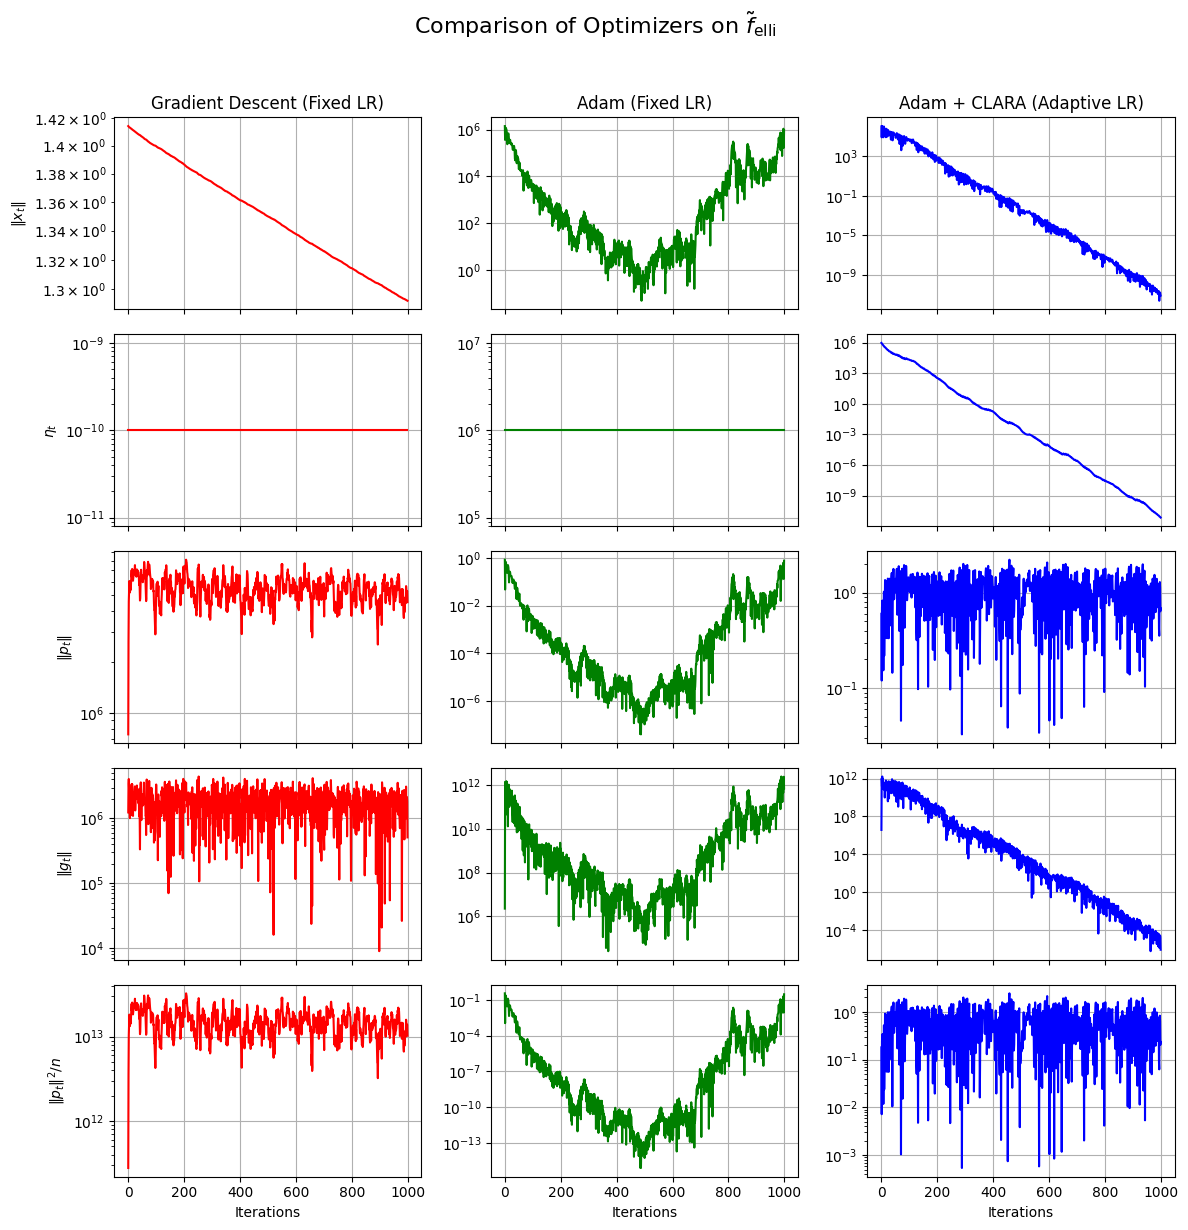

In [8]:
# Define row (metric) titles and y-axis labels
row_titles = ['Distance to Optimum', 'Learning Rate', 'Path Norm', 'Gradient Norm', 'Normalized Path Norm']
y_labels = [r'$\|x_t\|$', r'$\eta_t$', r'$\|p_t\|$', r'$\|g_t\|$', r'$\|p_t\|^2 / n$']

# Colors for each method's plots (one color per column)
colors = ['red', 'green', 'blue']

n_rows = len(row_titles)
n_cols = len(results_all)

# Set up the figure with one column per method and one row per metric
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2.5 * n_rows), sharex=True)
fig.suptitle(r'Comparison of Optimizers on $\tilde{f}_\mathrm{elli}$', fontsize=16)

# Plot each metric for each method
for col, (results, method, color) in enumerate(zip(results_all, method_names, colors)):
    for row in range(n_rows):
        # Get the current axis; if only one column, axes[row] would be used
        ax = axes[row, col] if n_cols > 1 else axes[row]
        ax.semilogy(results[row], color=color)
        if col == 0:
            ax.set_ylabel(y_labels[row])
        if row == 0:
            ax.set_title(method)
        ax.grid(True)
        if row == n_rows - 1:
            ax.set_xlabel('Iterations')

# Adjust layout to prevent overlap with the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

##### We tested...
- **GD with extremely small LR** (`1e-10`)
- **Adam with very large LR** (`1e6`)
- **Adam + CLARA** with the same large LR (`1e6`)
This was to compare **stability and adaptability** of the optimizers under mismatched or extreme learning rates.

----
### ✅ Summary of Findings

| Optimizer          | Behavior                | Verdict                     |
|--------------------|--------------------------|-----------------------------|
| GD, small LR       | Very slow, but stable    | Ineffective under noise     |
| Adam, large LR     | Unstable, noisy updates  | No built-in protection      |
| Adam + CLARA, large LR | Stable, adaptive, convergent | ✅ Success case for paper |

These plots demonstrate that:
> CLARA enables stable and effective optimization under extreme learning rate settings, while fixed learning rate methods either fail to converge (Adam) or converge extremely slowly (GD).

🔜 Next steps
- Run on more realistic RL settings (e.g. tabular environments or simple Gym tasks)
- Compare to D-Adaptation and other advanced LR methods
- Theoretical analysis of stability and convergence (optional)
- Test across different condition numbers / dimensions to explore robustness

---